# Plot Rubin Galactic Plane Survey Footprint

In [61]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.cm import ScalarMappable
from matplotlib.collections import PolyCollection
from matplotlib.colors import Normalize, colorConverter
from matplotlib.patches import Ellipse
from astropy.coordinates import SkyCoord, HeliocentricTrueEcliptic, ICRS, Longitude
from os import path
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from rubin_scheduler import scheduler

In [28]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
print(str(NPIX) + ' HEALpixels corresponds to NSIDE=' + str(NSIDE))

49152 HEALpixels corresponds to NSIDE=64


Let's first load a map of stellar density of the Milky Way.

In [29]:
def load_star_density_data(config,limiting_mag=28.0):

    data_file = path.join(config['star_map_dir'], config['GP']['data_file'])
    if path.isfile(data_file):
        npz_file = np.load(data_file)
        with np.load(data_file) as npz_file:
            star_map = npz_file['starDensity']
            mag_bins = npz_file['bins']

            dmag = abs(mag_bins - limiting_mag)
            idx = np.where(dmag == dmag.min())[0]

            star_density_map = np.copy(star_map[:,idx]).flatten()
            star_density_map = hp.reorder(star_density_map, n2r=True)

        return star_density_map

    else:
        raise IOError('Cannot find star density map data file at '+data_file)

    return None

def rotateHealpix(hpmap, transf=['C','G'], phideg=0., thetadeg=0.):
    """Rotates healpix map from one system to the other. Returns reordered healpy map.
    Healpy coord transformations are used, or you can specify your own angles in degrees.
    To specify your own angles, ensure that transf has length != 2.
    Original code by Xiaolong Li
    """

    # For reasons I don't understand, entering in ['C', 'G'] seems to do the
    # transformation FROM galactic TO equatorial. Possibly something buried in
    # the conventions used by healpy.

    # Heavily influenced by stack overflow solution here:
    # https://stackoverflow.com/questions/24636372/apply-rotation-to-healpix-map-in-healpy

    nside = hp.npix2nside(len(hpmap))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

    # Define a rotator
    if len(transf) == 2:
        r = hp.Rotator(coord=transf)
    else:
        r = hp.Rotator(deg=True, rot=[phideg,thetadeg])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hpmap, trot, prot)

    return rot_map


In [30]:
config = {
    'star_map_dir': '/Users/rstreet/rubin_sim_data/maps/scheduler_maps/maps/TriMaps',
    'GP': {
        'data_file': "TRIstarDensity_r_nside_64_ext.npz"
    }
}
star_density_map = load_star_density_data(config,limiting_mag=27.5)
hp_star_density = rotateHealpix(star_density_map)
idx = hp_star_density > 0.0
hp_log_star_density = np.zeros(len(hp_star_density))
hp_log_star_density[idx] = np.log10(hp_star_density[idx])
print(hp_log_star_density)

[0.         0.         0.         ... 4.95336991 4.96741207 4.9395054 ]


These maps are arrays in HEALpixel index.  To plot this using matplotlib's functions we need to convert HEALpixel index to the RA, Dec of each HEALpixel

In [62]:
# From Desiutils
# Licensed under a 3-clause BSD style license - see LICENSE.rst
# -*- coding: utf-8 -*-
"""
==============
desiutil.plots
==============

Module for code plots.
"""
import os
import warnings
from datetime import date
from types import MethodType
import numpy as np
import numpy.ma
import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.cm import ScalarMappable
from matplotlib.collections import PolyCollection
from matplotlib.colors import Normalize, colorConverter
from matplotlib.patches import Ellipse
from astropy.coordinates import SkyCoord, HeliocentricTrueEcliptic, ICRS, Longitude
import astropy.units as u
from astropy.time import Time
from astropy.utils import iers

def plot_slices(x, y, x_lo, x_hi, y_cut, num_slices=5, min_count=100, axis=None,
                set_ylim_from_stats=True, scatter=True):
    """Scatter plot with 68, 95 percentiles superimposed in slices.
    Modified from code written by D. Kirkby

    Requires that the matplotlib package is installed.

    Parameters
    ----------
    x : array of :class:`float`
        X-coordinates to scatter plot.  Points outside [x_lo, x_hi] are
        not displayed.
    y : array of :class:`float`
        Y-coordinates to scatter plot.  Y values are assumed to be roughly
        symmetric about zero.
    x_lo : :class:`float`
        Minimum value of `x` to plot.
    x_hi : :class:`float`
        Maximum value of `x` to plot.
    y_cut : :class:`float`
        The target maximum value of :math:`|y|`.  A dashed line at this value
        is added to the plot, and the vertical axis is clipped at
        :math:`|y|` = 1.25 * `y_cut` (but values outside this range are
        included in the percentile statistics).
    num_slices : :class:`int`, optional
        Number of equally spaced slices to divide the interval [x_lo, x_hi]
        into.
    min_count : :class:`int`, optional
        Do not use slices with fewer points for superimposed percentile
        statistics.
    axis : :class:`matplotlib.axes.Axes`, optional
        Uses the current axis if this is not set.
    set_ylim_from_stats : :class:`bool`, optional
        Set ylim of plot from 95% stat.
    scatter : bool, optional
        Show the data as a scatter plot.
        Best to limit to small datasets

    Returns
    -------
    :class:`matplotlib.axes.Axes`
        The Axes object used in the plot.
    """
    if axis is None:
        axis = plt.gca()

    x_bins = np.linspace(x_lo, x_hi, num_slices + 1)
    x_i = np.digitize(x, x_bins) - 1
    limits = []
    counts = []
    for s in range(num_slices):
        # Calculate percentile statistics for ok fits.
        y_slice = y[(x_i == s)]
        counts.append(len(y_slice))
        if counts[-1] > 0:
            limits.append(np.percentile(y_slice, (2.5, 16, 50, 84, 97.5)))
        else:
            limits.append((0., 0., 0., 0., 0.))
    limits = np.array(limits)
    counts = np.array(counts)

    # Plot points
    if scatter:
        axis.scatter(x, y, s=15, marker='.', lw=0, color='b', alpha=0.5, zorder=1)

    # Plot quantiles in slices with enough fits.
    stepify = lambda y: np.vstack([y, y]).transpose().flatten()
    y_m2 = stepify(limits[:, 0])
    y_m1 = stepify(limits[:, 1])
    y_med = stepify(limits[:, 2])
    y_p1 = stepify(limits[:, 3])
    y_p2 = stepify(limits[:, 4])
    xstack = stepify(x_bins)[1:-1]
    max_yr, max_p2, min_m2 = 0., -1e9, 1e9
    for i in range(num_slices):
        s = slice(2 * i, 2 * i + 2)
        if counts[i] >= min_count:
            axis.fill_between(
                xstack[s], y_m2[s], y_p2[s], alpha=0.15, color='red', zorder=10)
            axis.fill_between(
                xstack[s], y_m1[s], y_p1[s], alpha=0.25, color='red', zorder=10)
            axis.plot(xstack[s], y_med[s], 'r-', lw=2.)
            # For ylim
            max_yr = max(max_yr, np.max(y_p2[s]-y_m2[s]))
            max_p2 = max(max_p2, np.max(y_p2[s]))
            min_m2 = min(min_m2, np.min(y_m2[s]))

    # xlim
    xmin, xmax = np.min(x), np.max(x)
    axis.set_xlim(np.min(x)-(xmax-xmin)*0.02, np.max(x)+(xmax-xmin)*0.02)

    # ylim
    if set_ylim_from_stats:
        axis.set_ylim(min_m2-max_yr/2., max_p2+max_yr/2.)

    # Plot cut lines.
    axis.axhline(+y_cut, ls=':', color='k')
    axis.axhline(0., ls='-', color='k')
    axis.axhline(-y_cut, ls=':', color='k')

    return axis


class MaskedArrayWithLimits(numpy.ma.MaskedArray):
    """Masked array with additional `vmin`, `vmax` attributes.

    This class accepts the same arguments as
    :class:`~numpy.ma.MaskedArray`.

    This is not a general-purpose subclass and is only intended to simplify
    passing `vmin`, `vmax` limits from :func:`~desiutil.plots.prepare_data` to
    the plotting utility methods defined in this module.

    Parameters
    ----------
    vmin : :class:`float`, optional
        Minimum value when used for clipping or masking.
    vmax : :class:`float`, optional
        Maximum value when used for clipping or masking.

    Attributes
    ----------
    vmin : :class:`float`
        Minimum value when used for clipping or masking.
    vmax : :class:`float`
        Maximum value when used for clipping or masking.
    """
    def __new__(cls, *args, **kwargs):
        try:
            obj = super(MaskedArrayWithLimits, cls).__new__(cls, *args, **kwargs)
        except TypeError:
            # Numpy >= 1.20.0
            trimmed_kwargs = kwargs.copy()
            if 'vmin' in trimmed_kwargs:
                del trimmed_kwargs['vmin']
            if 'vmax' in trimmed_kwargs:
                del trimmed_kwargs['vmax']
            obj = super(MaskedArrayWithLimits, cls).__new__(cls, *args, **trimmed_kwargs)
        if 'vmin' in kwargs:
            obj._optinfo['vmin'] = kwargs['vmin']
        #     obj.vmin = kwargs['vmin']
        # else:
        #     obj.vmin = None
        if 'vmax' in kwargs:
            obj._optinfo['vmax'] = kwargs['vmax']
        #     obj.vmax = kwargs['vmax']
        # else:
        #     obj.vmax = None
        return obj

    @property
    def vmin(self):
        return self._optinfo.get('vmin', None)

    @property
    def vmax(self):
        return self._optinfo.get('vmax', None)


def prepare_data(data, mask=None, clip_lo=None, clip_hi=None,
                 save_limits=False):
    """Prepare array data for color mapping.

    Data is clipped and masked to be suitable for passing to matplotlib
    routines that automatically assign colors based on input values.

    Parameters
    ----------
    data : array or masked array
        Array of data values to assign colors for.
    mask : array of bool or None
        Array of bools with same shape as data, where True values indicate
        values that should be ignored when assigning colors.  When None, the
        mask of a masked array will be used or all values of an unmasked
        array will be used.
    clip_lo : float or str
        Data values below clip_lo will be clipped to the minimum color. If
        clip_lo is a string, it should end with "%" and specify a percentile
        of un-masked data to clip below.
    clip_hi : float or str
        Data values above clip_hi will be clipped to the maximum color. If
        clip_hi is a string, it should end with "%" and specify a percentile
        of un-masked data to clip above.
    save_limits : bool
        Save the calculated lo/hi clip values as attributes vmin, vmax of
        the returned masked array.  Use this flag to indicate that plotting
        functions should use these vmin, vmax values when mapping the
        returned data to colors.

    Returns
    -------
    masked array
        Masked numpy array with the same shape as the input data, with any
        input mask applied (or copied from an input masked array) and values
        clipped to [clip_lo, clip_hi].

    Examples
    --------
    If no optional parameters are specified, the input data is returned
    with only non-finite values masked:

    >>> data = np.arange(5.)
    >>> prepare_data(data)
    masked_array(data = [0.0 1.0 2.0 3.0 4.0],
                 mask = [False False False False False],
           fill_value = 1e+20)
    <BLANKLINE>

    Any mask selection is propagated to the output:

    >>> prepare_data(data, data == 2)
    masked_array(data = [0.0 1.0 -- 3.0 4.0],
                 mask = [False False  True False False],
           fill_value = 1e+20)
    <BLANKLINE>

    Values can be clipped by specifying any combination of percentiles
    (specified as strings ending with "%") and numeric values:

    >>> prepare_data(data, clip_lo='25%', clip_hi=3.5)
    masked_array(data = [1.0 1.0 2.0 3.0 3.5],
                 mask = [False False False False False],
           fill_value = 1e+20)
    <BLANKLINE>

    Clipped values are also masked when the clip value or percentile
    is prefixed with "!":

    >>> prepare_data(data, clip_lo='!25%', clip_hi=3.5)
    masked_array(data = [-- 1.0 2.0 3.0 3.5],
                 mask = [ True False False False False],
           fill_value = 1e+20)
    <BLANKLINE>

    An input masked array is passed through without any copying unless
    clipping is requested:

    >>> masked = numpy.ma.arange(5)
    >>> masked is prepare_data(masked)
    True

    Use the save_limits option to store the clipping limits as vmin, vmax
    attributes of the returned object:

    >>> d = prepare_data(data, clip_lo=1, clip_hi=10, save_limits=True)
    >>> d.vmin, d.vmax
    (1.0, 10.0)

    These attributes can then be used by plotting routines to fix the input
    range used for colormapping, independently of the actual range of data.
    """
    data = np.asanyarray(data)
    if mask is None:
        try:
            # Use the mask associated with a MaskedArray.
            cmask = data.mask
            # If no clipping is requested, pass the input through.
            if clip_lo is None and clip_hi is None:
                return data
        except AttributeError:
            # Nothing is masked by default.
            cmask = np.zeros_like(data, dtype=bool)
    else:
        #
        # Make every effort to ensure that modifying the mask of the output
        # does not modify the input mask.
        #
        cmask = np.array(mask)
        if cmask.shape != data.shape:
            raise ValueError('Invalid mask shape.')
    # Mask any non-finite values.
    cmask |= ~np.isfinite(data)
    unmasked_data = data[~cmask]

    # Convert percentile clip values to absolute values.
    def get_clip(value):
        clip_mask = False
        if isinstance(value, str):
            if value.startswith('!'):
                clip_mask = True
                value = value[1:]
            if value.endswith('%'):
                value = np.percentile(unmasked_data, float(value[:-1]))
        return float(value), clip_mask

    if clip_lo is None:
        clip_lo, mask_lo = np.min(unmasked_data), False
    else:
        clip_lo, mask_lo = get_clip(clip_lo)
    if clip_hi is None:
        clip_hi, mask_hi = np.max(unmasked_data), False
    else:
        clip_hi, mask_hi = get_clip(clip_hi)

    if save_limits:
        clipped = MaskedArrayWithLimits(
            np.clip(data, clip_lo, clip_hi), cmask, vmin=clip_lo, vmax=clip_hi)
    else:
        clipped = numpy.ma.MaskedArray(
            np.clip(data, clip_lo, clip_hi), cmask)

    # Mask values outside the clip range, if requested.  The comparisons
    # below might trigger warnings for non-finite data.
    settings = np.seterr(all='ignore')
    if mask_lo:
        clipped.mask[data < clip_lo] = True
    if mask_hi:
        clipped.mask[data > clip_hi] = True
    np.seterr(**settings)

    return clipped


def init_sky(projection='mollweide', ra_center=120,
             galactic_plane_color='red', ecliptic_plane_color='red',
             ax=None):
    """Initialize matplotlib axes with a projection of the full sky.

    Parameters
    ----------
    projection : :class:`str`, optional
        Projection to use. Defaults to 'mollweide'.  To show the available projections,
        call :func:`matplotlib.projections.get_projection_names`.
    ra_center : :class:`float`, optional
        Projection is centered at this RA in degrees. Default is +120°, which avoids splitting
        the DESI northern and southern regions.
    galactic_plane_color : color name, optional
        Draw a solid curve representing the galactic plane using the specified color, or do
        nothing when ``None``.
    ecliptic_plane_color : color name, optional
        Draw a dotted curve representing the ecliptic plane using the specified color, or do
        nothing when ``None``.
    ax : :class:`~matplotlib.axes.Axes`, optional
        Axes to use for drawing this map, or create new axes if ``None``.

    Returns
    -------
    :class:`~matplotlib.axes.Axes`
        A matplotlib Axes object.  Helper methods ``projection_ra()`` and ``projection_dec()``
        are added to the object to facilitate conversion to projection coordinates.

    Notes
    -----
    If requested, the ecliptic and galactic planes are plotted with ``zorder`` set to 20.
    This keeps them above most other plotted objects, but legends should be set to
    a ``zorder`` higher than this value, for example::

        leg = ax.legend(ncol=2, loc=1)
        leg.set_zorder(25)
    """
    #
    # Internal functions.
    #
    def projection_ra(self, ra):
        r"""Shift `ra` to the origin of the Axes object and convert to radians.

        Parameters
        ----------
        ra : array-like
            Right Ascension in degrees.

        Returns
        -------
        array-like
            `ra` converted to plot coordinates.

        Notes
        -----
        In matplotlib, map projections expect longitude (RA), latitude (Dec)
        in radians with limits :math:`[-\pi, \pi]`, :math:`[-\pi/2, \pi/2]`,
        respectively.
        """
        #
        # Shift RA values.
        #
        r = np.remainder(ra + 360 - ra_center, 360)
        #
        # Scale conversion to [-180, 180].
        #
        r[r > 180] -= 360
        #
        # Reverse the scale: East to the left.
        #
        r = -r
        return np.radians(r)

    def projection_dec(self, dec):
        """Shift `dec` to the origin of the Axes object and convert to radians.

        Parameters
        ----------
        dec : array-like
            Declination in degrees.

        Returns
        -------
        array-like
            `dec` converted to plot coordinates.
        """
        return np.radians(dec)
    #
    # Create ax.
    #
    if ax is None:
        fig = plt.figure(figsize=(10.0, 5.0), dpi=100)
        ax = plt.subplot(111, projection=projection)
    #
    # Prepare labels.
    #
    base_tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    base_tick_labels = np.remainder(base_tick_labels+360+ra_center, 360)
    tick_labels = np.array(['{0}°'.format(l) for l in base_tick_labels])
    #
    # Galactic plane.
    #
    if galactic_plane_color is not None:
        galactic_l = np.linspace(0, 2 * np.pi, 1000)
        galactic = SkyCoord(l=galactic_l*u.radian, b=np.zeros_like(galactic_l)*u.radian,
                            frame='galactic').transform_to(ICRS)
        #
        # Project to map coordinates and display.  Use a scatter plot to
        # avoid wrap-around complications.
        #
        paths = ax.scatter(projection_ra(0, galactic.ra.degree),
                           projection_dec(0, galactic.dec.degree),
                           marker='.', s=20, lw=0, alpha=0.75,
                           c=galactic_plane_color, zorder=20)
        # Make sure the galactic plane stays above other displayed objects.
        # paths.set_zorder(20)
    #
    # Ecliptic plane.
    #
    if ecliptic_plane_color is not None:
        ecliptic_l = np.linspace(0, 2 * np.pi, 50)
        ecliptic = SkyCoord(lon=ecliptic_l*u.radian, lat=np.zeros_like(ecliptic_l)*u.radian, distance=1 * u.Mpc,
                            frame='heliocentrictrueecliptic').transform_to(ICRS)
        #
        # Project to map coordinates and display.  Use a scatter plot to
        # avoid wrap-around complications.
        #
        paths = ax.scatter(projection_ra(0, ecliptic.ra.degree),
                           projection_dec(0, ecliptic.dec.degree),
                           marker='.', s=20, lw=0, alpha=0.75,
                           c=ecliptic_plane_color, zorder=20)
        # paths.set_zorder(20)
    #
    # Set RA labels.
    #
    labels = ax.get_xticklabels()
    for l, item in enumerate(labels):
        item.set_text(tick_labels[l])
    ax.set_xticklabels(labels)
    #
    # Set axis labels.
    #
    ax.set_xlabel('R.A. [deg]')
    # ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel('Dec. [deg]')
    # ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    #
    # Attach helper methods.
    #
    if hasattr(ax, '_ra_center'):
        warnings.warn("Attribute '_ra_center' detected.  Will be overwritten!")
    ax._ra_center = ra_center
    if hasattr(ax, 'projection_ra'):
        warnings.warn("Attribute 'projection_ra' detected.  Will be overwritten!")
    ax.projection_ra = MethodType(projection_ra, ax)
    if hasattr(ax, 'projection_dec'):
        warnings.warn("Attribute 'projection_dec' detected.  Will be overwritten!")
    ax.projection_dec = MethodType(projection_dec, ax)
    return ax


def plot_healpix_map(data, nest=False, cmap='viridis', colorbar=True,
                     label=None, ax=None, **kwargs):
    """Plot a healpix map using an all-sky projection.

    Pass the data array through :func:`prepare_data` to select a subset to plot
    and clip the color map to specified values or percentiles.

    This function is similar to :func:`plot_grid_map` but is generally slower
    at high resolution and has less elegant handling of pixels that wrap around
    in RA, which are not drawn.

    Requires that matplotlib and healpy are installed.

    Additional keyword parameters will be passed to :func:`init_sky`.

    Parameters
    ----------
    data : array or masked array
        1D array of data associated with each healpix.  Must have a size that
        exactly matches the number of pixels for some NSIDE value. Use the
        output of :func:`prepare_data` as a convenient way to specify
        data cuts and color map clipping.
    nest : :class:`bool`, optional
        If ``True``, assume NESTED pixel ordering.  Otheriwse, assume RING pixel
        ordering.
    cmap : colormap name or object, optional
        Matplotlib colormap to use for mapping data values to colors.
    colorbar : :class:`bool`, optional
        Draw a colorbar below the map when ``True``.
    label : :class:`str`, optional
        Label to display under the colorbar.  Ignored unless colorbar is ``True``.
    ax : :class:`~matplotlib.axes.Axes`, optional
        Axes to use for drawing this map, or create default axes using
        :func:`init_sky` when ``None``.

    Returns
    -------
    :class:`~matplotlib.axes.Axes`
        The axis object used for the plot.
    """
    import healpy as hp

    data = prepare_data(data)
    if len(data.shape) != 1:
        raise ValueError('Invalid data array, should be 1D.')
    nside = hp.npix2nside(len(data))
    #
    # Create axes.
    #
    if ax is None:
        print('Creating new plot axis')
        ax = init_sky(**kwargs)
    proj_edge = ax._ra_center - 180
    #
    # Find the projection edge.
    #
    while proj_edge < 0:
        proj_edge += 360
    #
    # Get pixel boundaries as quadrilaterals.
    #
    corners = hp.boundaries(nside, np.arange(len(data)), step=1, nest=nest)
    corner_theta, corner_phi = hp.vec2ang(corners.transpose(0, 2, 1))
    corner_ra, corner_dec = (np.degrees(corner_phi),
                             np.degrees(np.pi/2-corner_theta))
    #
    # Convert sky coords to map coords.
    #
    x, y = ax.projection_ra(corner_ra), ax.projection_dec(corner_dec)
    #
    # Regroup into pixel corners.
    #
    verts = np.array([x.reshape(-1, 4), y.reshape(-1, 4)]).transpose(1, 2, 0)
    #
    # Find and mask any pixels that wrap around in RA.
    #
    uv_verts = np.array([corner_phi.reshape(-1, 4),
                         corner_theta.reshape(-1, 4)]).transpose(1, 2, 0)
    theta_edge = np.unique(uv_verts[:, :, 1])
    phi_edge = np.radians(proj_edge)
    eps = 0.1 * np.sqrt(hp.nside2pixarea(nside))
    wrapped1 = hp.ang2pix(nside, theta_edge, phi_edge - eps, nest=nest)
    wrapped2 = hp.ang2pix(nside, theta_edge, phi_edge + eps, nest=nest)
    wrapped = np.unique(np.hstack((wrapped1, wrapped2)))
    data.mask[wrapped] = True
    #
    # Normalize the data using its vmin, vmax attributes, if present.
    #
    try:
        norm = Normalize(vmin=data.vmin, vmax=data.vmax)
    except AttributeError:
        norm = None
    #
    # Make the collection and add it to the plot.
    #
    collection = PolyCollection(verts, array=data, cmap=cmap, norm=norm,
                                edgecolors='none')
    ax.add_collection(collection)
    ax.autoscale_view()

    if colorbar:
        bar = plt.colorbar(collection, ax=ax,
                           orientation='horizontal', spacing='proportional',
                           pad=0.11, fraction=0.05, aspect=50)
        if label:
            bar.set_label(label)

    return ax


def plot_grid_map(data, ra_edges, dec_edges, cmap='viridis', colorbar=True,
                  label=None, ax=None, **kwargs):
    r"""Plot an array of 2D values using an all-sky projection.

    Pass the data array through :func:`prepare_data` to select a subset to plot
    and clip the color map to specified values or percentiles.

    This function is similar to :func:`plot_healpix_map` but is generally faster
    and has better handling of RA wrap around artifacts.

    Additional keyword parameters will be passed to :func:`init_sky`.

    Parameters
    ----------
    data : array or masked array
        2D array of data associated with each grid cell, with shape
        :math:`(N_{\mathrm{RA}}, N_{\mathrm{Dec}})`.
        Use the output of :func:`prepare_data` as a convenient
        way to specify data cuts and color map clipping.
    ra_edges : array
        1D array of :math:`N_{\mathrm{RA}} + 1` RA grid edge values in degrees,
        which must span the full circle, *i.e.*,
        ``ra_edges[0] == ra_edges[-1] - 360``. The RA grid does not need to match
        the edges of the projection, in which case any wrap-around cells will
        be duplicated on both edges.
    dec_edges : array
        1D array of :math:`N_{\mathrm{Dec}} + 1` Dec grid edge values in degrees.
        Values are not required to span the full range ``[-90, +90]``.
    cmap : colormap name or object, optional
        Matplotlib colormap to use for mapping data values to colors.
    colorbar : :class:`bool`, optional
        Draw a colorbar below the map when ``True``.
    label : :class:`str`, optional
        Label to display under the colorbar.  Ignored unless colorbar is ``True``.
    ax : :class:`~matplotlib.axes.Axes`, optional
        Axes to use for drawing this map, or create default axes using
        :func:`init_sky` when ``None``.

    Returns
    -------
    :class:`~matplotlib.axes.Axes`
        The axis object used for the plot.
    """
    data = prepare_data(data)
    if len(data.shape) != 2:
        raise ValueError('Expected 2D data array.')
    n_dec, n_ra = data.shape
    #
    # Normalize the data using its vmin, vmax attributes, if present.
    # Need to do this before hstack-ing below, which drops vmin, vmax.
    #
    try:
        norm = Normalize(vmin=data.vmin, vmax=data.vmax)
    except AttributeError:
        norm = None
    #
    # Silently flatten, sort, and remove duplicates from the edges arrays.
    #
    ra_edges = np.unique(ra_edges)
    dec_edges = np.unique(dec_edges)
    if len(ra_edges) != n_ra + 1:
        raise ValueError('Invalid ra_edges.')
    if len(dec_edges) != n_dec + 1:
        raise ValueError('Invalid dec_edges.')
    if ra_edges[0] != ra_edges[-1] - 360:
        raise ValueError('Invalid ra_edges, do not span 360 degrees.')
    #
    # Create axes.
    #
    if ax is None:
        ax = init_sky(**kwargs)
    #
    # Find the projection edge.
    #
    proj_edge = ax._ra_center - 180
    while proj_edge < 0:
        proj_edge += 360
    #
    # Find the first RA gridline that fits within the map's right edge.
    #
    first = np.where(ra_edges >= proj_edge)[0][0]
    if first > 0:
        # Wrap the data beyond the left edge around to the right edge.
        # Remember to use numpy.ma.hstack for the data to preserve the mask.
        if ra_edges[first] > proj_edge:
            # Split a wrap-around column into separate left and right columns.
            ra_edges = np.hstack(([proj_edge], ra_edges[first:],
                                  ra_edges[1:first] + 360, [proj_edge+360]))
            data = numpy.ma.hstack((data[:, (first - 1):first],
                                    data[:, first:],
                                    data[:, :(first - 1)],
                                    data[:, (first - 1):first]))
        else:
            # One of the ra_edge values is exactly on the edge.
            ra_edges = np.hstack((ra_edges[first:], ra_edges[:(first + 1)] + 360))
            data = numpy.ma.hstack((data[:, first:], data[:, :(first + 1)]))

    # Transform to projection coordinates.  By construction, the first value should be positive.
    proj_ra = ax.projection_ra(ra_edges)
    if proj_ra[0] < 0:
        proj_ra[0] *= -1

    # Build a 2D array of grid line intersections.
    grid_ra, grid_dec = np.meshgrid(proj_ra, ax.projection_dec(dec_edges))

    ax.grid(False)
    mesh = ax.pcolormesh(grid_ra, grid_dec,
                         data, cmap=cmap, norm=norm, edgecolor='none', lw=0)

    # grid turned off for pcolormesh; turn it back on.
    ax.grid(True)

    if colorbar:
        bar = plt.colorbar(mesh, ax=ax,
                           orientation='horizontal', spacing='proportional',
                           pad=0.1, fraction=0.05, aspect=50)
        if label:
            bar.set_label(label)

    return ax


def plot_sky_circles(ra_center, dec_center, field_of_view=3.2, data=None,
                     cmap='viridis', facecolors='skyblue', edgecolor='none',
                     colorbar=True, colorbar_ticks=None, label=None,
                     ax=None, **kwargs):
    """Plot circles on an all-sky projection.

    Pass the optional data array through :func:`prepare_data` to select a
    subset to plot and clip the color map to specified values or percentiles.

    Requires that matplotlib is installed.

    Additional keyword parameters will be passed to :func:`init_sky`.

    Parameters
    ----------
    ra_center : array
        1D array of RA in degrees at the centers of each circle to plot.
    dec_center : array
        1D array of DEC in degrees at the centers of each circle to plot.
    field_of_view : array
        Full sky openning angle in degrees of the circles to plot. The default
        is appropriate for a DESI tile.
    data : array, optional
        1D array of data associated with each circle, used to set its facecolor.
    cmap : colormap name, optional
        Matplotlib colormap to use for mapping data values to colors. Ignored
        unless data is specified.
    facecolors : matplotlib color or array of colors, optional
        Ignored when data is specified. An array must have one entry per circle
        or a single value is used for all circles.
    edgecolor : matplotlib color, optional
        The edge color used for all circles.  Use 'none' to hide edges.
    colorbar : :class:`bool`, optional
        Draw a colorbar below the map when ``True`` and data is provided.
    colorbar_ticks : :class:`list`, optional
        Use the specified colorbar ticks or determine them automatically
        when None.
    label : :class:`str`
        Label to display under the colorbar.  Ignored unless a colorbar is
        displayed.
    ax : :class:`~matplotlib.axes.Axes`, optional
        Axes to use for drawing this map, or create default axes using
        :func:`init_sky` when ``None``.

    Returns
    -------
    :class:`~matplotlib.axes.Axes`
        The axis object used for the plot.
    """
    ra_center = np.asarray(ra_center)
    dec_center = np.asarray(dec_center)
    if len(ra_center.shape) != 1:
        raise ValueError('Invalid ra_center, must be a 1D array.')
    if len(dec_center.shape) != 1:
        raise ValueError('Invalid dec_center, must be a 1D array.')
    if len(ra_center) != len(dec_center):
        raise ValueError('Arrays ra_center, dec_center must have same size.')

    if data is not None:
        data = prepare_data(data)
        # Facecolors are determined by the data, when specified.
        if data.shape != ra_center.shape:
            raise ValueError('Invalid data shape, must match ra_center.')
        # Colors associated with masked values in data will be ignored later.
        try:
            # Normalize the data using its vmin, vmax attributes, if present.
            norm = Normalize(vmin=data.vmin, vmax=data.vmax)
        except AttributeError:
            # Otherwise use the data limits.
            norm = Normalize(vmin=data.min(), vmax=data.max())
        cmapper = ScalarMappable(norm, cmap)
        facecolors = cmapper.to_rgba(data)
    else:
        colorbar = False
        # Try to repeat a single fixed color for all circles.
        try:
            facecolors = np.tile(
                [colorConverter.to_rgba(facecolors)],
                (len(ra_center), 1))
        except ValueError:
            # Assume that facecolor is already an array.
            facecolors = np.asarray(facecolors)

    if len(facecolors) != len(ra_center):
        raise ValueError('Invalid facecolor array.')

    if ax is None:
        ax = init_sky(**kwargs)
    #
    # Find the projection edge.
    #
    proj_edge = ax._ra_center - 180
    while proj_edge < 0:
        proj_edge += 360
    #
    # Convert field-of-view angle into dRA.
    #
    dRA = field_of_view / np.cos(np.radians(dec_center))
    #
    # Identify circles that wrap around the map edges in RA.
    #
    edge_dist = np.fabs(np.fmod(ra_center - proj_edge, 360))
    wrapped = np.minimum(edge_dist, 360 - edge_dist) < 1.05 * 0.5 * dRA  # convert dRA to radius.
    #
    # Loop over non-wrapped circles.
    #
    for ra, dec, dra, fc in zip(ax.projection_ra(ra_center[~wrapped]), ax.projection_dec(dec_center[~wrapped]),
                                dRA[~wrapped], facecolors[~wrapped]):
        e = Ellipse((ra, dec), np.radians(dra), np.radians(field_of_view),
                    facecolor=fc, edgecolor=edgecolor)
        ax.add_patch(e)

    if colorbar:
        mappable = ScalarMappable(norm=norm, cmap=cmap)
        mappable.set_array(data)
        bar = plt.colorbar(mappable, ax=ax,
                           orientation='horizontal', spacing='proportional',
                           pad=0.1, fraction=0.05, aspect=50,
                           ticks=colorbar_ticks)
        if label:
            bar.set_label(label)

    return ax


def plot_sky_binned(ra, dec, weights=None, data=None, plot_type='grid',
                    max_bin_area=5, clip_lo=None, clip_hi=None, verbose=False,
                    cmap='viridis', colorbar=True, label=None, ax=None,
                    return_grid_data=False, **kwargs):
    """Show objects on the sky using a binned plot.

    Bin values either show object counts per unit sky area or, if an array
    of associated data values is provided, mean data values within each bin.
    Objects can have associated weights.

    Requires that matplotlib is installed. When plot_type is
    "healpix", healpy must also be installed.

    Additional keyword parameters will be passed to :func:`init_sky`.

    Parameters
    ----------
    ra : array
        Array of object RA values in degrees. Must have the same shape as
        dec and will be flattened if necessary.
    dec : array
        Array of object Dec values in degrees. Must have the same shape as
        ra and will be flattened if necessary.
    weights : array, optional
        Optional of weights associated with each object.  All objects are
        assumed to have equal weight when this is None.
    data : array, optional
        Optional array of scalar values associated with each object. The
        resulting plot shows the mean data value per bin when data is
        specified.  Otherwise, the plot shows counts per unit sky area.
    plot_type : {'grid', 'healpix'}
        Must be either 'grid' or 'healpix', and selects whether data in
        binned in healpix or in (sin(Dec), RA).
    max_bin_area : :class:`float`, optional
        The bin size will be chosen automatically to be as close as
        possible to this value but not exceeding it.
    clip_lo : :class:`float` or :class:`str`, optional
        Clipping is applied to the plot data calculated as counts / area
        or the mean data value per bin. See :func:`prepare_data` for
        details.
    clip_hi : :class:`float` or :class:`str`, optional
        Clipping is applied to the plot data calculated as counts / area
        or the mean data value per bin. See :func:`prepare_data` for
        details.
    verbose : :class:`bool`, optional
        Print information about the automatic bin size calculation.
    cmap : colormap name or object, optional
        Matplotlib colormap to use for mapping data values to colors.
    colorbar : :class:`bool`, optional
        Draw a colorbar below the map when True.
    label : :class:`str`, optional
        Label to display under the colorbar.  Ignored unless colorbar is ``True``.
    ax : :class:`~matplotlib.axes.Axes`, optional
        Axes to use for drawing this map, or create default axes using
        :func:`init_sky` when ``None``.
    return_grid_data : :class:`bool`, optional
        If ``True``, return (ax, grid_data) instead of just ax.

    Returns
    -------
    :class:`~matplotlib.axes.Axes` or (ax, grid_data)
        The axis object used for the plot, and the grid_data if
        `return_grid_data` is ``True``.
    """
    ra = np.asarray(ra).reshape(-1)
    dec = np.asarray(dec).reshape(-1)
    if len(ra) != len(dec):
        raise ValueError('Arrays ra,dec must have same size.')

    plot_types = ('grid', 'healpix',)
    if plot_type not in plot_types:
        raise ValueError('Invalid plot_type, should be one of {0}.'.format(', '.join(plot_types)))

    if data is not None and weights is None:
        weights = np.ones_like(data)

    if plot_type == 'grid':
        # Convert the maximum pixel area to steradians.
        max_bin_area = max_bin_area * (np.pi / 180.) ** 2

        # Pick the number of bins in cos(DEC) and RA to use.
        n_cos_dec = int(np.ceil(2 / np.sqrt(max_bin_area)))
        n_ra = int(np.ceil(4 * np.pi / max_bin_area / n_cos_dec))
        # Calculate the actual pixel area in sq. degrees.
        bin_area = 360 ** 2 / np.pi / (n_cos_dec * n_ra)
        if verbose:
            print('Using {0} x {1} grid in cos(DEC) x RA'.format(n_cos_dec, n_ra),
                  'with pixel area {:.3f} sq.deg.'.format(bin_area))

        # Calculate the bin edges in degrees.
        # ra_edges = np.linspace(-180., +180., n_ra + 1)
        ra_edges = np.linspace(0.0, 360.0, n_ra + 1)
        dec_edges = np.degrees(np.arcsin(np.linspace(-1., +1., n_cos_dec + 1)))

        # Put RA values in the range [-180, 180).
        # ra = np.fmod(ra, 360.)
        # ra[ra >= 180.] -= 360.

        # Histogram the input coordinates.
        counts, _, _ = np.histogram2d(dec, ra, [dec_edges, ra_edges],
                                      weights=weights)

        if data is None:
            grid_data = counts / bin_area
        else:
            sums, _, _ = np.histogram2d(dec, ra, [dec_edges, ra_edges],
                                        weights=weights * data)
            # This ratio might result in some nan (0/0) or inf (1/0) values,
            # but these will be masked by prepare_data().
            settings = np.seterr(all='ignore')
            grid_data = sums / counts
            np.seterr(**settings)

        grid_data = prepare_data(grid_data, clip_lo=clip_lo, clip_hi=clip_hi)

        ax = plot_grid_map(grid_data, ra_edges, dec_edges,
                           cmap=cmap, colorbar=colorbar, label=label,
                           ax=ax, **kwargs)

    elif plot_type == 'healpix':

        import healpy as hp

        for n in range(1, 25):
            nside = 2 ** n
            bin_area = hp.nside2pixarea(nside, degrees=True)
            if bin_area <= max_bin_area:
                break
        npix = hp.nside2npix(nside)
        nest = False
        if verbose:
            print('Using healpix map with NSIDE={0}'.format(nside),
                  'and pixel area {:.3f} sq.deg.'.format(bin_area))

        pixels = hp.ang2pix(nside, np.radians(90 - dec), np.radians(ra), nest)
        counts = np.bincount(pixels, weights=weights, minlength=npix)
        if data is None:
            grid_data = counts / bin_area
        else:
            sums = np.bincount(pixels, weights=weights * data, minlength=npix)
            grid_data = np.zeros_like(sums, dtype=float)
            nonzero = counts > 0
            grid_data[nonzero] = sums[nonzero] / counts[nonzero]

        grid_data = prepare_data(grid_data, clip_lo=clip_lo, clip_hi=clip_hi)

        ax = plot_healpix_map(grid_data, nest=nest,
                              cmap=cmap, colorbar=colorbar, label=label,
                              ax=ax, **kwargs)

    if return_grid_data:
        return (ax, grid_data)
    else:
        return ax


In [66]:
def calc_polycollection(data, ax, cmap='viridis'):
    """
    Refactored from plot_healpix_map above
    """
    data = prepare_data(data)
    if len(data.shape) != 1:
        raise ValueError('Invalid data array, should be 1D.')
    nside = hp.npix2nside(len(data))
    
    proj_edge = ax._ra_center - 180
    #
    # Find the projection edge.
    #
    while proj_edge < 0:
        proj_edge += 360
    #
    # Get pixel boundaries as quadrilaterals.
    #
    corners = hp.boundaries(nside, np.arange(len(data)), step=1, nest=nest)
    corner_theta, corner_phi = hp.vec2ang(corners.transpose(0, 2, 1))
    corner_ra, corner_dec = (np.degrees(corner_phi),
                             np.degrees(np.pi/2-corner_theta))
    #
    # Convert sky coords to map coords.
    #
    x, y = ax.projection_ra(corner_ra), ax.projection_dec(corner_dec)
    #
    # Regroup into pixel corners.
    #
    verts = np.array([x.reshape(-1, 4), y.reshape(-1, 4)]).transpose(1, 2, 0)
    #
    # Find and mask any pixels that wrap around in RA.
    #
    uv_verts = np.array([corner_phi.reshape(-1, 4),
                         corner_theta.reshape(-1, 4)]).transpose(1, 2, 0)
    theta_edge = np.unique(uv_verts[:, :, 1])
    phi_edge = np.radians(proj_edge)
    eps = 0.1 * np.sqrt(hp.nside2pixarea(nside))
    wrapped1 = hp.ang2pix(nside, theta_edge, phi_edge - eps, nest=nest)
    wrapped2 = hp.ang2pix(nside, theta_edge, phi_edge + eps, nest=nest)
    wrapped = np.unique(np.hstack((wrapped1, wrapped2)))
    data.mask[wrapped] = True
    #
    # Normalize the data using its vmin, vmax attributes, if present.
    #
    try:
        norm = Normalize(vmin=data.vmin, vmax=data.vmax)
    except AttributeError:
        norm = None
    #
    # Make the collection and add it to the plot.
    #
    collection = PolyCollection(verts, array=data, cmap=cmap, norm=norm,
                                edgecolors='none')
    
    return collection
    

Creating new plot axis


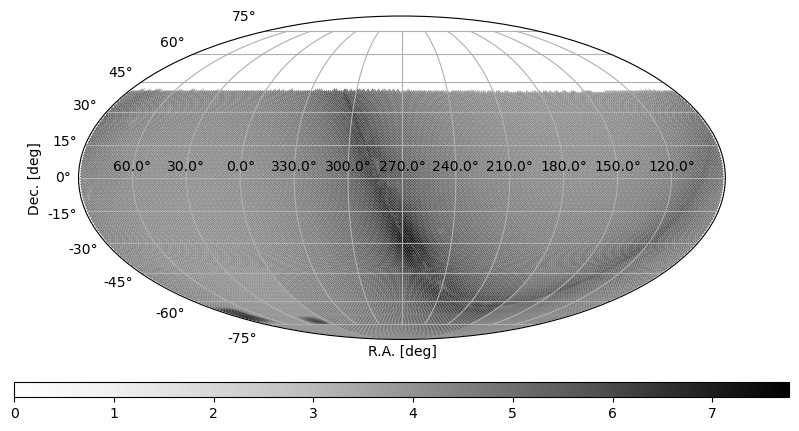

In [75]:
nest = False
kwargs = {'ra_center':270.0, 'cmap': 'Greys'}
#kwargs = {'projection': 'aitoff'}
ax = plot_healpix_map(hp_log_star_density, nest, galactic_plane_color=None, ecliptic_plane_color=None, **kwargs)

In [76]:
sky_area = scheduler.utils.sky_area.EuclidOverlapFootprint()
healmaps, pix_labels = sky_area.return_maps()

mask = pix_labels == 'bulgy'

survey_footprint = np.zeros(hp.nside2npix(sky_area.nside))
survey_footprint[mask] = 1.0

# The default map has a lower NSIDE than used for the map data, so resample
survey_footprint = hp.ud_grade(survey_footprint, NSIDE)


In [96]:
def plot_healpix_map2(data1, data2, nest=False, cmap='viridis', colorbar=True,
                     label=None, ax=None, **kwargs):
    """Plot a healpix map using an all-sky projection; adapted to plot overlays.

    Pass the data array through :func:`prepare_data` to select a subset to plot
    and clip the color map to specified values or percentiles.

    This function is similar to :func:`plot_grid_map` but is generally slower
    at high resolution and has less elegant handling of pixels that wrap around
    in RA, which are not drawn.

    Requires that matplotlib and healpy are installed.

    Additional keyword parameters will be passed to :func:`init_sky`.

    Parameters
    ----------
    data : array or masked array
        1D array of data associated with each healpix.  Must have a size that
        exactly matches the number of pixels for some NSIDE value. Use the
        output of :func:`prepare_data` as a convenient way to specify
        data cuts and color map clipping.
    nest : :class:`bool`, optional
        If ``True``, assume NESTED pixel ordering.  Otheriwse, assume RING pixel
        ordering.
    cmap : colormap name or object, optional
        Matplotlib colormap to use for mapping data values to colors.
    colorbar : :class:`bool`, optional
        Draw a colorbar below the map when ``True``.
    label : :class:`str`, optional
        Label to display under the colorbar.  Ignored unless colorbar is ``True``.
    ax : :class:`~matplotlib.axes.Axes`, optional
        Axes to use for drawing this map, or create default axes using
        :func:`init_sky` when ``None``.

    Returns
    -------
    :class:`~matplotlib.axes.Axes`
        The axis object used for the plot.
    """
    import healpy as hp

    data1 = prepare_data(data1)
    data2 = prepare_data(data2)
    if len(data1.shape) != 1 or len(data2.shape) != 1:
        raise ValueError('Invalid data arrays, should be 1D.')
    nside = hp.npix2nside(len(data1))
    #
    # Create axes.
    #
    if ax is None:
        print('Creating new plot axis')
        ax = init_sky(**kwargs)
    proj_edge = ax._ra_center - 180
    #
    # Find the projection edge.
    #
    while proj_edge < 0:
        proj_edge += 360
    #
    # Get pixel boundaries as quadrilaterals.
    #
    corners = hp.boundaries(nside, np.arange(len(data1)), step=1, nest=nest)
    corner_theta, corner_phi = hp.vec2ang(corners.transpose(0, 2, 1))
    corner_ra, corner_dec = (np.degrees(corner_phi),
                             np.degrees(np.pi/2-corner_theta))
    #
    # Convert sky coords to map coords.
    #
    x, y = ax.projection_ra(corner_ra), ax.projection_dec(corner_dec)
    #
    # Regroup into pixel corners.
    #
    verts = np.array([x.reshape(-1, 4), y.reshape(-1, 4)]).transpose(1, 2, 0)
    #
    # Find and mask any pixels that wrap around in RA.
    #
    uv_verts = np.array([corner_phi.reshape(-1, 4),
                         corner_theta.reshape(-1, 4)]).transpose(1, 2, 0)
    theta_edge = np.unique(uv_verts[:, :, 1])
    phi_edge = np.radians(proj_edge)
    eps = 0.1 * np.sqrt(hp.nside2pixarea(nside))
    wrapped1 = hp.ang2pix(nside, theta_edge, phi_edge - eps, nest=nest)
    wrapped2 = hp.ang2pix(nside, theta_edge, phi_edge + eps, nest=nest)
    wrapped = np.unique(np.hstack((wrapped1, wrapped2)))
    data1.mask[wrapped] = True
    data2.mask[wrapped] = True
    #
    # Normalize the data using its vmin, vmax attributes, if present.
    #
    try:
        norm = Normalize(vmin=data1.vmin, vmax=data1.vmax)
    except AttributeError:
        norm = None
    #
    # Make the collection and add it to the plot.
    #
    collection1 = PolyCollection(verts, array=data1, cmap=cmap, norm=norm,
                                edgecolors='none')
    collection2 = PolyCollection(verts, array=data2, cmap='viridis', norm=norm,
                                edgecolors='none', alpha=0.2)
    ax.add_collection(collection1)
    ax.add_collection(collection2)
    ax.autoscale_view()

    if colorbar:
        bar = plt.colorbar(collection1, ax=ax,
                           orientation='horizontal', spacing='proportional',
                           pad=0.11, fraction=0.05, aspect=50)
        if label:
            bar.set_label(label)

    return ax

Creating new plot axis


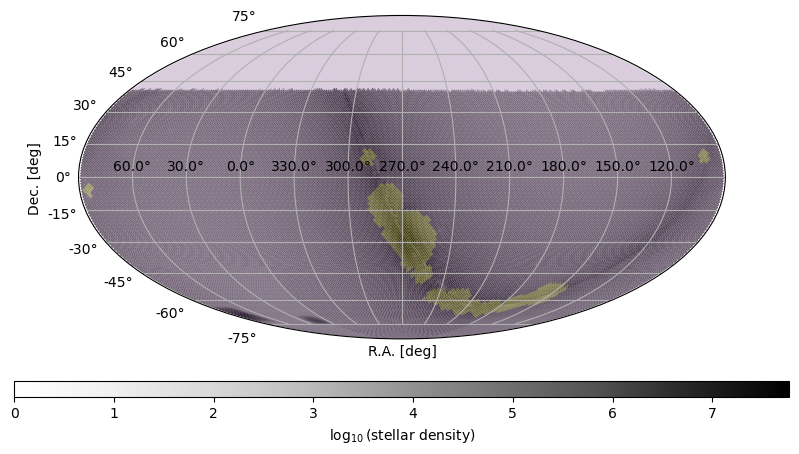

In [98]:
kwargs = {
    'ra_center':270.0, 
    'cmap': 'Greys',
    'label': '$\\log_{10}$(stellar density)'
}
ax = plot_healpix_map2(hp_log_star_density, survey_footprint, nest, galactic_plane_color=None, ecliptic_plane_color=None, **kwargs)
plt.savefig('/Users/rstreet/LSST/SCOC/Rubin_GalPlane_survey_footprint.png')